# Control of a "spacecraft" platform with a reaction wheel

In [1]:
# These are standard modules
import numpy as np
import sympy as sym
from scipy import linalg
from IPython.display import display, Latex, Markdown

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Given a choice of ground roll angle $\phi$, the equations of motion are

$$
\begin{aligned}
J_1 \ddot{q}_1 &= \tau - m_wgl\sin(q_1)\sin(\phi) \\
J_2 \ddot{q}_2 &= - \left( \dfrac{J_1 + J_2}{J_1} \right) \tau + \left( \dfrac{J_2}{J_1} \right) m_wgl\sin(q_1)\sin(\phi)
\end{aligned}
$$

where

* $q_1$ is the platform angle
* $q_2$ is the wheel angle
* $\tau$ is the torque applied *to* the platform *by* the wheel

and

$$
J_1 = J_p + m_wl^2
\qquad
\qquad
J_2 = J_w.
$$

These equations can be written in standard form as

$$
\begin{bmatrix}
    \dot{q}_1 \\
    \dot{v}_1 \\
    \dot{q}_2 \\
    \dot{v}_2
\end{bmatrix}
=
\begin{bmatrix}
    v_1 \\
    \left( \tau - m_wgl\sin(q_1)\sin(\phi) \right) / J_1 \\
    v_2 \\
    \left( -\left((J_1 + J_2) / J_2\right) \tau + m_wgl\sin(q_1)\sin(\phi) \right) / J_1
\end{bmatrix}
$$

where

* $v_1$ is the platform velocity
* $v_2$ is the wheel velocity.

Parameter values are defined as follows:

In [2]:
# distance from platform axis to wheel axis
l = 1.

# radius of wheel
rw = 0.5

# mass of wheel
mw = 0.25

# moi of wheel
Jw = 0.5 * mw * rw**2

# mass of platform
mp = 12. * (1. - mw * l**2) / (3.**2 + 2.**2)

# moment of inertia of platform
Jp = (1. / 12.) * mp * (3.**2 + 2.**2)

# gravity
g = 9.81

# composite parameters
J1 = Jp + mw * l**2
J2 = Jw

Get equations of motion in standard form for platform and wheel in gravity.

In [3]:
# Define variables
q1, v1, q2, v2, tau = sym.symbols('q1, v1, q2, v2, tau')

# Define right-hand side of ODEs
f = sym.Matrix([
    v1,
    (1 / J1) * (tau - mw * g * l * sym.sin(q1)),
    v2,
    (1 / J2) * (- ((J1 + J2) / J1) * tau + (J2 / J1) * mw * g * l * sym.sin(q1))
])

# Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)

# Show EOMs
mdot_str = r'\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{q}_2 \\ \dot{v}_2 \end{bmatrix}'
m_str = r'\begin{bmatrix} q_1 \\ v_1 \\ q_2 \\ v_2 \end{bmatrix}'
n_str = r'\begin{bmatrix} \tau \end{bmatrix}'

display(Markdown(fr'$$\LARGE {mdot_str} = f\left( {m_str}, {n_str} \right) = {sym.latex(f)}$$'))

$$\LARGE \begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{q}_2 \\ \dot{v}_2 \end{bmatrix} = f\left( \begin{bmatrix} q_1 \\ v_1 \\ q_2 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right) = \left[\begin{matrix}v_{1}\\\tau - \frac{981 \sin{\left(q_{1} \right)}}{400}\\v_{2}\\- 33 \tau + \frac{981 \sin{\left(q_{1} \right)}}{400}\end{matrix}\right]$$

## How do find an equilibrium point numerically (through minimization of a cost)

Create lambda function to allow numerical evalution of the function

$$ f \left( \begin{bmatrix} q_1 \\ v_1 \\ q_2 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right). $$

In [4]:
f_num = sym.lambdify([q1, v1, q2, v2, tau], f)

This function takes five arguments (four elements of the state and one element of the input) and returns the right-hand side of the EOMs as a 2D numpy array. Here is an example (does the result imply that we have found an equilibrium point?):

In [6]:
print(f_num(0.1, 0.2, 0.3, 0.4, 0.5))

[[  0.2       ]
 [  0.25515855]
 [  0.4       ]
 [-16.25515855]]


Import the `minimize` function from `scipy.optimize`.

In [7]:
from scipy.optimize import minimize

Create lambda function to allow numerical evaluation of the **cost function**

$$\left\| f \left( \begin{bmatrix} q_1 \\ v_1 \\ q_2 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right) \right\|^2.$$

The condition that

$$ f \left( \begin{bmatrix} q_1 \\ v_1 \\ q_2 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right) = 0 $$

is equivalent to the condition that

$$\min_{q_1, v_1, q_2, v_2, \tau} \quad \left\| f \left( \begin{bmatrix} q_1 \\ v_1 \\ q_2 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right) \right\|^2 = 0.$$

In [8]:
f_num_for_minimize = lambda x: np.linalg.norm(f_num(x[0], x[1], x[2], x[3], x[4]).flatten())**2

# Could also have written this more compactly as follows:
#
#  f_num_for_minimize = lambda x: np.linalg.norm(f_num(*x).flatten())**2
#

Show an example of evaluating this cost function (does the result imply that we have found an equilibrium point?):

In [9]:
print(f_num_for_minimize([
    0.1, # <-- guess at q_1_e
    0.2, # <-- guess at v_1_e
    0.3, # <-- guess at q_2_e
    0.4, # <-- guess at v_2_e
    0.5, # <-- guess at tau_e
]))

264.4952852284176


Minimize the cost function to find an equilibrium point, starting from some initial guess. (If this process does not converge, then either no equilibrium point exists or the initial guess was too far from an equilibrium point.)

In [10]:
# Initial guess
x0 = [
    0.1, # <-- guess at q_1_e
    0.2, # <-- guess at v_1_e
    0.3, # <-- guess at q_2_e
    0.4, # <-- guess at v_2_e
    0.5, # <-- guess at tau_e
]

# Find minimum ("tol" is a tolerance that says how accurate you want the solution)
sol = minimize(f_num_for_minimize, x0, tol=1e-4)

# Show solution
print(sol)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 8.538608434679795e-13
        x: [ 3.015e-07  1.256e-07  3.000e-01  2.584e-07  7.696e-09]
      nit: 5
      jac: [ 6.150e-06  2.660e-07  0.000e+00  5.317e-07 -1.727e-05]
 hess_inv: [[ 8.931e-02  2.563e-04 ...  5.125e-04  6.816e-03]
            [ 2.563e-04  9.001e-01 ... -1.998e-01  1.454e-05]
            ...
            [ 5.125e-04 -1.998e-01 ...  6.003e-01  2.908e-05]
            [ 6.816e-03  1.454e-05 ...  2.908e-05  9.789e-04]]
     nfev: 48
     njev: 8


Parse solution.

In [11]:
# Get equilibrium point
q1e = sol.x[0]
v1e = sol.x[1]
q2e = sol.x[2]
v2e = sol.x[3]
taue = sol.x[4]

# Could also have written this more compactly as follows:
#
#   (q1e, v1e, q2e, v2e, taue) = sol.x
#

# Show equilibrium point
print(f'  q1e = {q1e:7.3f}')
print(f'  v1e = {v1e:7.3f}')
print(f'  q2e = {q2e:7.3f}')
print(f'  v2e = {v2e:7.3f}')
print(f' taue = {taue:7.3f}')

  q1e =   0.000
  v1e =   0.000
  q2e =   0.300
  v2e =   0.000
 taue =   0.000


The equilibrium point you find with this method depends on the choice of initial guess.

In [12]:
# Initial guess
x0 = [
    3.1, # <-- guess at q_1_e
    3.2, # <-- guess at v_1_e
    3.3, # <-- guess at q_2_e
    3.4, # <-- guess at v_2_e
    3.5, # <-- guess at tau_e
]

# Find minimum ("tol" is a tolerance that says how accurate you want the solution)
sol = minimize(f_num_for_minimize, x0, tol=1e-4)

# Show solution
print(sol)
print('')

# Get equilibrium point
q1e = sol.x[0]
v1e = sol.x[1]
q2e = sol.x[2]
v2e = sol.x[3]
taue = sol.x[4]

# Could also have written this more compactly as follows:
#
#   (q1e, v1e, q2e, v2e, taue) = sol.x
#

# Show equilibrium point
print(f'  q1e = {q1e:7.3f}')
print(f'  v1e = {v1e:7.3f}')
print(f'  q2e = {q2e:7.3f}')
print(f'  v2e = {v2e:7.3f}')
print(f' taue = {taue:7.3f}')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.2643949842853122e-13
        x: [ 3.142e+00  9.338e-08  3.300e+00 -8.408e-08 -1.463e-08]
      nit: 10
      jac: [-5.019e-08  2.017e-07  0.000e+00 -1.533e-07 -3.272e-07]
 hess_inv: [[ 8.849e-02  2.557e-05 ... -3.337e-05 -6.755e-03]
            [ 2.557e-05  7.653e-01 ... -2.495e-01 -5.870e-05]
            ...
            [-3.337e-05 -2.495e-01 ...  7.349e-01 -5.784e-05]
            [-6.755e-03 -5.870e-05 ... -5.784e-05  9.746e-04]]
     nfev: 84
     njev: 14

  q1e =   3.142
  v1e =   0.000
  q2e =   3.300
  v2e =  -0.000
 taue =  -0.000


The equilibrium point found may be very far from the initial guess.

In [13]:
# Initial guess
x0 = [
    2.1, # <-- guess at q_1_e
    3.2, # <-- guess at v_1_e
    3.3, # <-- guess at q_2_e
    3.4, # <-- guess at v_2_e
    3.5, # <-- guess at tau_e
]

# Find minimum ("tol" is a tolerance that says how accurate you want the solution)
sol = minimize(f_num_for_minimize, x0, tol=1e-4)

# Show solution
print(sol)
print('')

# Get equilibrium point
q1e = sol.x[0]
v1e = sol.x[1]
q2e = sol.x[2]
v2e = sol.x[3]
taue = sol.x[4]

# Could also have written this more compactly as follows:
#
#   (q1e, v1e, q2e, v2e, taue) = sol.x
#

# Show equilibrium point
print(f'  q1e = {q1e:7.3f} (but notice that q1e = {q1e / np.pi:.0f} * pi)')
print(f'  v1e = {v1e:7.3f}')
print(f'  q2e = {q2e:7.3f}')
print(f'  v2e = {v2e:7.3f}')
print(f' taue = {taue:7.3f}')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.464634212387601e-11
        x: [ 3.142e+01  3.594e-06  3.300e+00 -3.398e-06 -1.817e-08]
      nit: 11
      jac: [-6.688e-07  7.204e-06  0.000e+00 -6.780e-06  3.518e-06]
 hess_inv: [[ 8.843e-02 -2.100e-03 ...  2.372e-03  6.759e-03]
            [-2.100e-03  7.634e-01 ... -2.497e-01 -8.618e-06]
            ...
            [ 2.372e-03 -2.497e-01 ...  7.356e-01  6.492e-05]
            [ 6.759e-03 -8.618e-06 ...  6.492e-05  9.752e-04]]
     nfev: 102
     njev: 17

  q1e =  31.416 (but notice that q1e = 10 * pi)
  v1e =   0.000
  q2e =   3.300
  v2e =  -0.000
 taue =  -0.000


## How to choose a subset of states (i.e., a sub-system)

Suppose what we actually want is for the platform to be some desired angle (with zero platform velocity) and for the wheel velocity to be some desired **non-zero** angular rate.

Every equilibrium point we found has

$$ v_{2e} = 0. $$

This result implies that it may not be possible to find an equilibrium point for the full system that corresponds to what we want. We need to choose a sub-system.

### Q1: Why must $v_{2e}=0$ for the full system?

Look at the EOMs again.

In [14]:
display(Markdown(fr'$$\LARGE {mdot_str} = f\left( {m_str}, {n_str} \right) = {sym.latex(f)}$$'))

$$\LARGE \begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{q}_2 \\ \dot{v}_2 \end{bmatrix} = f\left( \begin{bmatrix} q_1 \\ v_1 \\ q_2 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right) = \left[\begin{matrix}v_{1}\\\tau - \frac{981 \sin{\left(q_{1} \right)}}{400}\\v_{2}\\- 33 \tau + \frac{981 \sin{\left(q_{1} \right)}}{400}\end{matrix}\right]$$

Look at the third EOM in particular.

In [ ]:
display(Markdown(fr'$$\LARGE \dot{{q}}_2 = {sym.latex(f[2])}$$'))

At equilibrium, therefore, it must be true that

$$ 0 = v_{2e}. $$

If we want $v_{2e} \neq 0$, then we **must** get rid of the third EOM.

Can we?

Does the right-hand side of the first EOM depend on $v_2$?

In [ ]:
display(Markdown(fr'$$\LARGE \dot{{q}}_1 = {sym.latex(f[0])}$$'))

Does the right-hand side of the second EOM depend on $v_2$?

In [ ]:
display(Markdown(fr'$$\LARGE \dot{{v}}_1 = {sym.latex(f[1])}$$'))

Does the right-hand side of the fourth EOM depend on $v_2$?

In [ ]:
display(Markdown(fr'$$\LARGE \dot{{v}}_1 = {sym.latex(f[3])}$$'))

No, no, no. So — yes, we can get rid of the third EOM. How?

In [15]:
# Get rows 0, 1, and 3 of f (dropping row 2)
f_reduced = f[[0, 1, 3], :]

# Show the result
mdot_str = r'\begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{v}_2 \end{bmatrix}'
m_str = r'\begin{bmatrix} q_1 \\ v_1 \\ v_2 \end{bmatrix}'
n_str = r'\begin{bmatrix} \tau \end{bmatrix}'
display(Markdown(fr'$$\LARGE {mdot_str} = f\left( {m_str}, {n_str} \right) = {sym.latex(f_reduced)}$$'))

$$\LARGE \begin{bmatrix} \dot{q}_1 \\ \dot{v}_1 \\ \dot{v}_2 \end{bmatrix} = f\left( \begin{bmatrix} q_1 \\ v_1 \\ v_2 \end{bmatrix}, \begin{bmatrix} \tau \end{bmatrix} \right) = \left[\begin{matrix}v_{1}\\\tau - \frac{981 \sin{\left(q_{1} \right)}}{400}\\- 33 \tau + \frac{981 \sin{\left(q_{1} \right)}}{400}\end{matrix}\right]$$

Try again to find an equilibrium point.

In [16]:
# Lambda function to evaluate f_reduced
f_num = sym.lambdify([q1, v1, v2, tau], f_reduced)

# Lambda function to evalaute the cost function for minimization (i.e., the norm squared of f_reduced)
f_num_for_minimize = lambda x: np.linalg.norm(f_num(*x).flatten())**2

# Initial guess
x0 = [
    0.1, # <-- guess at q_1_e
    0.2, # <-- guess at v_1_e
    0.4, # <-- guess at v_2_e
    0.5, # <-- guess at tau_e
]

# Find minimum ("tol" is a tolerance that says how accurate you want the solution)
sol = minimize(f_num_for_minimize, x0, tol=1e-4)

# Show solution
print(sol)
print('')

# Get equilibrium point
(q1e, v1e, v2e, taue) = sol.x

# Show equilibrium point
print(f'  q1e = {q1e:7.3f}')
print(f'  v1e = {v1e:7.3f}')
print(f'  v2e = {v2e:7.3f}')
print(f' taue = {taue:7.3f}')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.539084839199535e-13
        x: [-1.252e-07 -7.410e-09  4.000e-01 -1.732e-08]
      nit: 5
      jac: [ 5.543e-08  8.193e-11  0.000e+00 -6.319e-07]
 hess_inv: [[ 8.849e-02  9.222e-09  0.000e+00  6.769e-03]
            [ 9.222e-09  5.000e-01  0.000e+00 -1.838e-08]
            [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
            [ 6.769e-03 -1.838e-08  0.000e+00  9.767e-04]]
     nfev: 45
     njev: 9

  q1e =  -0.000
  v1e =  -0.000
  v2e =   0.400
 taue =  -0.000


Like before, the result depends on our initial guess.

In [17]:
# Lambda function to evaluate f_reduced
f_num = sym.lambdify([q1, v1, v2, tau], f_reduced)

# Lambda function to evalaute the cost function for minimization (i.e., the norm squared of f_reduced)
f_num_for_minimize = lambda x: np.linalg.norm(f_num(*x).flatten())**2

# Initial guess
x0 = [
    3.1, # <-- guess at q_1_e
    0.2, # <-- guess at v_1_e
    -1.4, # <-- guess at v_2_e
    0.5, # <-- guess at tau_e
]

# Find minimum ("tol" is a tolerance that says how accurate you want the solution)
sol = minimize(f_num_for_minimize, x0, tol=1e-4)

# Show solution
print(sol)
print('')

# Get equilibrium point
(q1e, v1e, v2e, taue) = sol.x

# Show equilibrium point
print(f'  q1e = {q1e:7.3f}')
print(f'  v1e = {v1e:7.3f}')
print(f'  v2e = {v2e:7.3f}')
print(f' taue = {taue:7.3f}')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.0094897905986955e-11
        x: [ 3.142e+00  2.108e-07 -1.400e+00 -7.946e-08]
      nit: 5
      jac: [ 1.829e-05  4.366e-07  0.000e+00  6.043e-05]
 hess_inv: [[ 8.924e-02 -3.917e-04  0.000e+00 -6.821e-03]
            [-3.917e-04  5.002e-01  0.000e+00  2.672e-05]
            [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
            [-6.821e-03  2.672e-05  0.000e+00  9.800e-04]]
     nfev: 40
     njev: 8

  q1e =   3.142
  v1e =   0.000
  v2e =  -1.400
 taue =  -0.000


Once we have an equilibrium point, we can proceed to linearize as usual.

In [18]:
# Verify equilibrium point
if not np.allclose(f_num(q1e, v1e, v2e, taue), 0.):
    raise Exception('equilibrium point is invalid')

# Find A and B in symbolic form
A_sym = f_reduced.jacobian([q1, v1, v2])
B_sym = f_reduced.jacobian([tau])

# Create lambda functions to allow numerical evaluation of A and B
A_num = sym.lambdify([q1, v1, v2, tau], A_sym)
B_num = sym.lambdify([q1, v1, v2, tau], B_sym)

# Find A and B in numeric form (making sure the result is floating-point)
A = A_num(q1e, v1e, v2e, taue).astype(float)
B = B_num(q1e, v1e, v2e, taue).astype(float)

# Show state-space model
print(f'A =\n{A}\n\nB =\n{B}')

Exception: equilibrium point is invalid

Wait, what happened?

In [19]:
print(f_num(q1e, v1e, v2e, taue))

[[ 0.00000021]
 [ 0.00000312]
 [-0.00000058]]


Ah, the equilibrium point isn't perfectly accurate. It is probably accurate enough. Try again, without the verification.

In [20]:
# Find A and B in symbolic form
A_sym = f_reduced.jacobian([q1, v1, v2])
B_sym = f_reduced.jacobian([tau])

# Create lambda functions to allow numerical evaluation of A and B
A_num = sym.lambdify([q1, v1, v2, tau], A_sym)
B_num = sym.lambdify([q1, v1, v2, tau], B_sym)

# Find A and B in numeric form (making sure the result is floating-point)
A = A_num(q1e, v1e, v2e, taue).astype(float)
B = B_num(q1e, v1e, v2e, taue).astype(float)

# Show state-space model
print(f'A =\n{A}\n\nB =\n{B}')

A =
[[ 0.      1.      0.    ]
 [ 2.4525  0.      0.    ]
 [-2.4525  0.      0.    ]]

B =
[[  0.]
 [  1.]
 [-33.]]


## How to apply LQR to design a controller

Define a function that returns the solution to the LQR problem

$$\begin{align*} \underset{u_{[t_0,\infty]}}{\text{minimize}} &\qquad\int_{t_0}^{\infty} \left( x(t)^T Q x(t) + u(t)^T R u(t) \right) dt\\ \text{subject to} &\qquad\dot{x}(t)=Ax(t)+Bu(t) \\ &\qquad x(t_0)=x_0. \end{align*}$$

In [21]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K, P

Choose weights.

In [22]:
Q = np.diag([1., 1., 1.])
R = np.diag([1.])

Find optimal gain matrix (and cost matrix).

In [23]:
K, P = lqr(A, B, Q, R)
print(f'K =\n{K}\n')

K =
[[106.63052913  69.10070717   1.        ]]



Find closed-loop eigenvalues.

In [24]:
# Show closed-loop eigenvalues
print(f'p = {linalg.eigvals(A - B @ K)}')

p = [-33.01745617+0.j          -1.5416255 +0.01775691j
  -1.5416255 -0.01775691j]


Create an instance of the simulator.

In [25]:
import matplotlib.pyplot as plt
import ae353_platform

simulator = ae353_platform.Simulator(
    display=True,
    roll=0.,
)

pybullet build time: Sep  3 2024 12:57:43


argv[0]=
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


Set ground roll angle of simulator.

In [26]:
simulator.set_roll(np.pi / 2)

Implement controller.

In [27]:
# Define controller
class Controller:
    def __init__(self, K, q1e, v1e, v2e, taue):
        self.K = K
        self.q1e = q1e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            wheel_angle,
            wheel_velocity,
        ):
        
        x = np.array([
            platform_angle - self.q1e,
            platform_velocity - self.v1e,
            wheel_velocity - self.v2e,
        ])
        u = - self.K @ x

        wheel_torque = - (u[0] + self.taue)
        
        return wheel_torque

Set up simulation.

In [28]:
# Create instance of controller
controller = Controller(K, q1e, v1e, v2e, taue)

# Reset simulator
simulator.reset(
    platform_angle=(np.pi - 0.25),
    platform_velocity=0.,
    wheel_angle=0.,
    wheel_velocity=0.,
)

# Reset controller
controller.reset()

Run simulation.

In [29]:
# Run simulator
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=10.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Plot results.

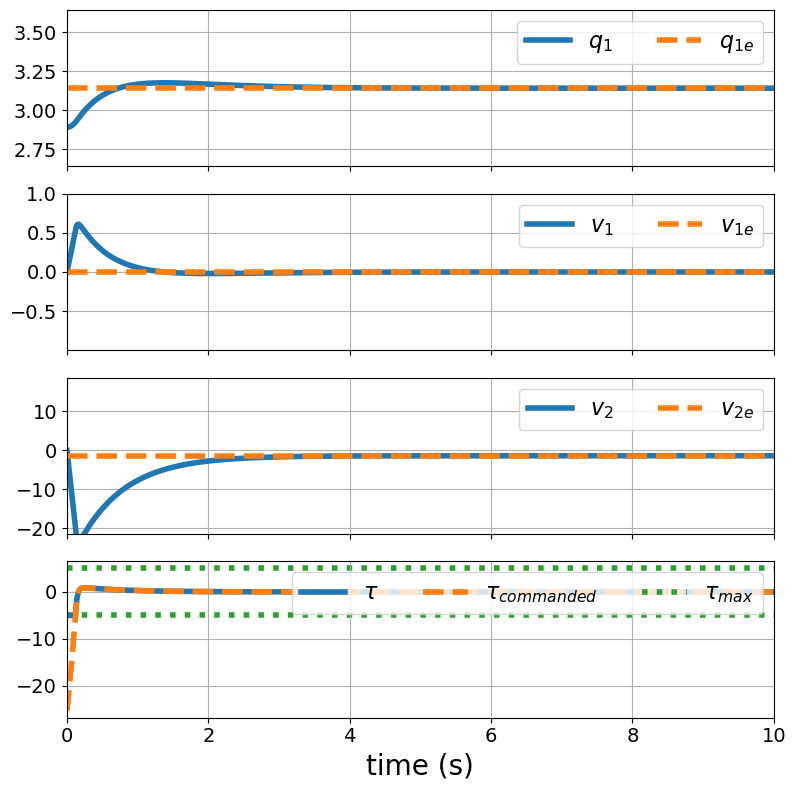

In [30]:
t = data['t']
q1 = data['platform_angle']
v1 = data['platform_velocity']
v2 = data['wheel_velocity']
tau = data['wheel_torque']
tau_command = data['wheel_torque_command']

fig, (ax_q1, ax_v1, ax_v2, ax_tau) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

ax_q1.plot(t, q1, label='$q_1$', linewidth=4)
ax_q1.plot(t, q1e * np.ones_like(t), '--', label='$q_{1e}$', linewidth=4)
ax_v1.plot(t, v1, label='$v_1$', linewidth=4)
ax_v1.plot(t, v1e * np.ones_like(t), '--', label='$v_{1e}$', linewidth=4)
ax_v2.plot(t, v2, label='$v_2$', linewidth=4)
ax_v2.plot(t, v2e * np.ones_like(t), '--', label='$v_{2e}$', linewidth=4)
ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
ax_tau.plot(t, tau_command, '--', label=r'$\tau_{commanded}$', linewidth=4)
ax_tau.plot(t, np.ones_like(t) * simulator.tau_max, ':', label=r'$\tau_{max}$', linewidth=4, color='C2', zorder=0)
ax_tau.plot(t, - np.ones_like(t) * simulator.tau_max, ':', linewidth=4, color='C2', zorder=0)

ax_q1.grid()
ax_q1.legend(fontsize=16, ncol=2, loc='upper right')
ax_q1.tick_params(labelsize=14)
ax_q1.set_ylim(q1e - 0.5, q1e + 0.5)

ax_v1.grid()
ax_v1.legend(fontsize=16, ncol=2, loc='upper right')
ax_v1.tick_params(labelsize=14)
ax_v1.set_ylim(v1e - 1., v1e + 1.)

ax_v2.grid()
ax_v2.legend(fontsize=16, ncol=2, loc='upper right')
ax_v2.tick_params(labelsize=14)
ax_v2.set_ylim(v2e - 20., v2e + 20.)

ax_tau.grid()
ax_tau.legend(fontsize=16, ncol=3, loc='upper right')
ax_tau.tick_params(labelsize=14)

ax_tau.set_xlabel('time (s)', fontsize=20)
ax_tau.set_xlim([data['t'][0], data['t'][-1]])

fig.tight_layout()
plt.show()

Exactly the same process can be applied (for example) to your design project.